# __Mitre Data__

In this playbook we will be looking at collecting and analysing Mitre data.  
We will also look to standardise the output of the data in such a way that it can be merged with other data sources.  

# __Data Gathering__

## Mitre Attack Techniques

We will be using the Mitre Attack framework as our way to standardise techniques across all data sources.  
For a webpage showing this you can follow [this link](https://attack.mitre.org/matrices/enterprise/).  
In order to work with this programmatically we will be using the same data in JSON format from [here](https://github.com/mitre/cti/blob/master/enterprise-attack/enterprise-attack.json).


In [1]:
import requests
import json
import pandas as pd
import os.path

r = requests.get("https://raw.githubusercontent.com/mitre/cti/master/enterprise-attack/enterprise-attack.json").json()

if not os.path.isfile("Mitre_data/MITRE_Techniques.json"):
    with open("Mitre_data/MITRE_Techniques.json", "w") as file:
        json.dump(r, file, indent=4)

with open('Mitre_data/MITRE_Techniques.json','r') as f:
    data = json.loads(f.read())

df_tech = pd.json_normalize(data, record_path =['objects'])
df_tech.head()

,type,modified,name,x_mitre_data_sources,x_mitre_version,created,x_mitre_permissions_required,x_mitre_platforms,x_mitre_is_subtechnique,id,...,identity_class,aliases,x_mitre_aliases,labels,x_mitre_shortname,tactic_refs,x_mitre_collection_layers,x_mitre_data_source_ref,definition_type,definition.statement
0,attack-pattern,2020-03-20T15:56:55.022Z,/etc/passwd and /etc/shadow,"[Command: Command Execution, File: File Access]",1.0,2020-02-11T18:46:56.263Z,[root],[Linux],True,attack-pattern--d0b4fcdb-d67d-4ed2-99ce-788b12...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,attack-pattern,2021-07-28T01:04:39.141Z,ARP Cache Poisoning,"[Network Traffic: Network Traffic Content, Net...",1.1,2020-10-15T12:05:58.755Z,[User],"[Linux, Windows, macOS]",True,attack-pattern--cabe189c-a0e3-4965-a473-dcff00...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,attack-pattern,2021-06-07T19:23:33.039Z,AS-REP Roasting,[Active Directory: Active Directory Credential...,1.0,2020-08-24T13:43:00.028Z,[User],[Windows],True,attack-pattern--3986e7fd-a8e9-4ecb-bfc6-559208...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,attack-pattern,2020-07-22T21:36:52.825Z,Abuse Elevation Control Mechanism,"[Process: Process Metadata, Process: Process C...",1.0,2020-01-30T13:58:14.373Z,"[Administrator, User]","[Linux, macOS, Windows]",False,attack-pattern--67720091-eee3-4d2d-ae16-826456...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,attack-pattern,2021-10-17T14:51:49.334Z,Access Token Manipulation,"[Process: Process Creation, Process: Process M...",2.0,2017-12-14T16:46:06.044Z,"[User, Administrator]",[Windows],False,attack-pattern--dcaa092b-7de9-4a21-977f-7fcb77...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Within this JSON there are 15886 objects.  
These are broken down into the following high level categories.  

In [2]:
a = df_tech['type'].unique()
print(sorted(a))

['attack-pattern', 'course-of-action', 'identity', 'intrusion-set', 'malware', 'marking-definition', 'relationship', 'tool', 'x-mitre-data-component', 'x-mitre-data-source', 'x-mitre-matrix', 'x-mitre-tactic']


The objects of interest to us are attack-pattern as these relate to the techniques in the Mitre Att&ck Matrix.  
So we can clean up our dataframe a little.  

In [3]:
df_tech = df_tech[df_tech['type'] == "attack-pattern" ]
df_tech.reset_index().to_json("Mitre_data/MITRE_Techniques_edited.json",orient='records')
a = df_tech['type'].unique()
print(sorted(a))

['attack-pattern']


## Mitre Groups

We will now look into collecting data from Mitre regarding threat actor groups.  
For a webpage showing this you can follow [this link](https://attack.mitre.org/groups/).  
There does not seem to be an official location for this data in a format that is suitable for programmatic use.  
This means we will have to scrape the data and make it so.  

In [4]:
from bs4 import BeautifulSoup
import logging
import sys

if not os.path.isfile("Mitre_data/MITRE_Groups.json"):
    page = requests.get("https://attack.mitre.org/groups/").text
    soup = BeautifulSoup(page, "html.parser")
    table = soup.find("table", class_="table table-bordered table-alternate mt-2")
    df = pd.read_html(str(table))[0]
    ids = df["ID"].tolist()
    results = []
    no_ttps = ["G0017", "G0030", "G0055"]
    for i in ids:
        r = requests.get("https://attack.mitre.org/groups/" + i + "/" + i + "-enterprise-layer.json")
        if r.status_code == 200:
            results.append(r.json())
        if r.status_code == 404:
            r = requests.get("https://attack.mitre.org/groups/" + i + "/" + i + "-mobile-layer.json")
            if r.status_code == 200:
                results.append(r.json())
            if r.status_code == 404:
                if i in no_ttps:
                    pass
                else:
                    logging.error("A request to Mitre Groups Failed for ID " + i)
                    sys.exit(1)
    with open("Mitre_data/MITRE_Groups.json", "w") as file:
        json.dump(results, file, indent=4)

df_group = pd.read_json("Mitre_data/MITRE_Groups.json", orient='records')

df_group.head()

,description,name,domain,versions,techniques,gradient,legendItems
0,"Enterprise techniques used by admin@338, ATT&C...",admin@338 (G0018),enterprise-attack,"{'layer': '4.3', 'attack': '10', 'navigator': ...","[{'techniqueID': 'T1087', 'showSubtechniques':...","{'colors': ['#ffffff', '#66b1ff'], 'minValue':...","[{'label': 'used by admin@338', 'color': '#66b..."
1,Enterprise techniques used by Ajax Security Te...,Ajax Security Team (G0130),enterprise-attack,"{'layer': '4.3', 'attack': '10', 'navigator': ...","[{'techniqueID': 'T1555', 'showSubtechniques':...","{'colors': ['#ffffff', '#66b1ff'], 'minValue':...","[{'label': 'used by Ajax Security Team', 'colo..."
2,"Enterprise techniques used by Andariel, ATT&CK...",Andariel (G0138),enterprise-attack,"{'layer': '4.3', 'attack': '10', 'navigator': ...","[{'score': 1, 'techniqueID': 'T1005', 'showSub...","{'colors': ['#ffffff', '#66b1ff'], 'minValue':...","[{'label': 'used by Andariel', 'color': '#66b1..."
3,"Enterprise techniques used by APT-C-36, ATT&CK...",APT-C-36 (G0099),enterprise-attack,"{'layer': '4.3', 'attack': '10', 'navigator': ...","[{'techniqueID': 'T1059', 'showSubtechniques':...","{'colors': ['#ffffff', '#66b1ff'], 'minValue':...","[{'label': 'used by APT-C-36', 'color': '#66b1..."
4,"Enterprise techniques used by APT1, ATT&CK gro...",APT1 (G0006),enterprise-attack,"{'layer': '4.3', 'attack': '10', 'navigator': ...","[{'techniqueID': 'T1087', 'showSubtechniques':...","{'colors': ['#ffffff', '#66b1ff'], 'minValue':...","[{'label': 'used by APT1', 'color': '#66b1ff'}]"


# __Analysis__

We now have our key pieces of data from Mitre, that being the techniques and the threat actors.  
This means we can start analysing this data by itself.  

## Technique Frequency

We can start by ranking the techniques (rolling up the sub-techniques) by how often they are seen across the threat actors.

<BarContainer object of 20 artists>

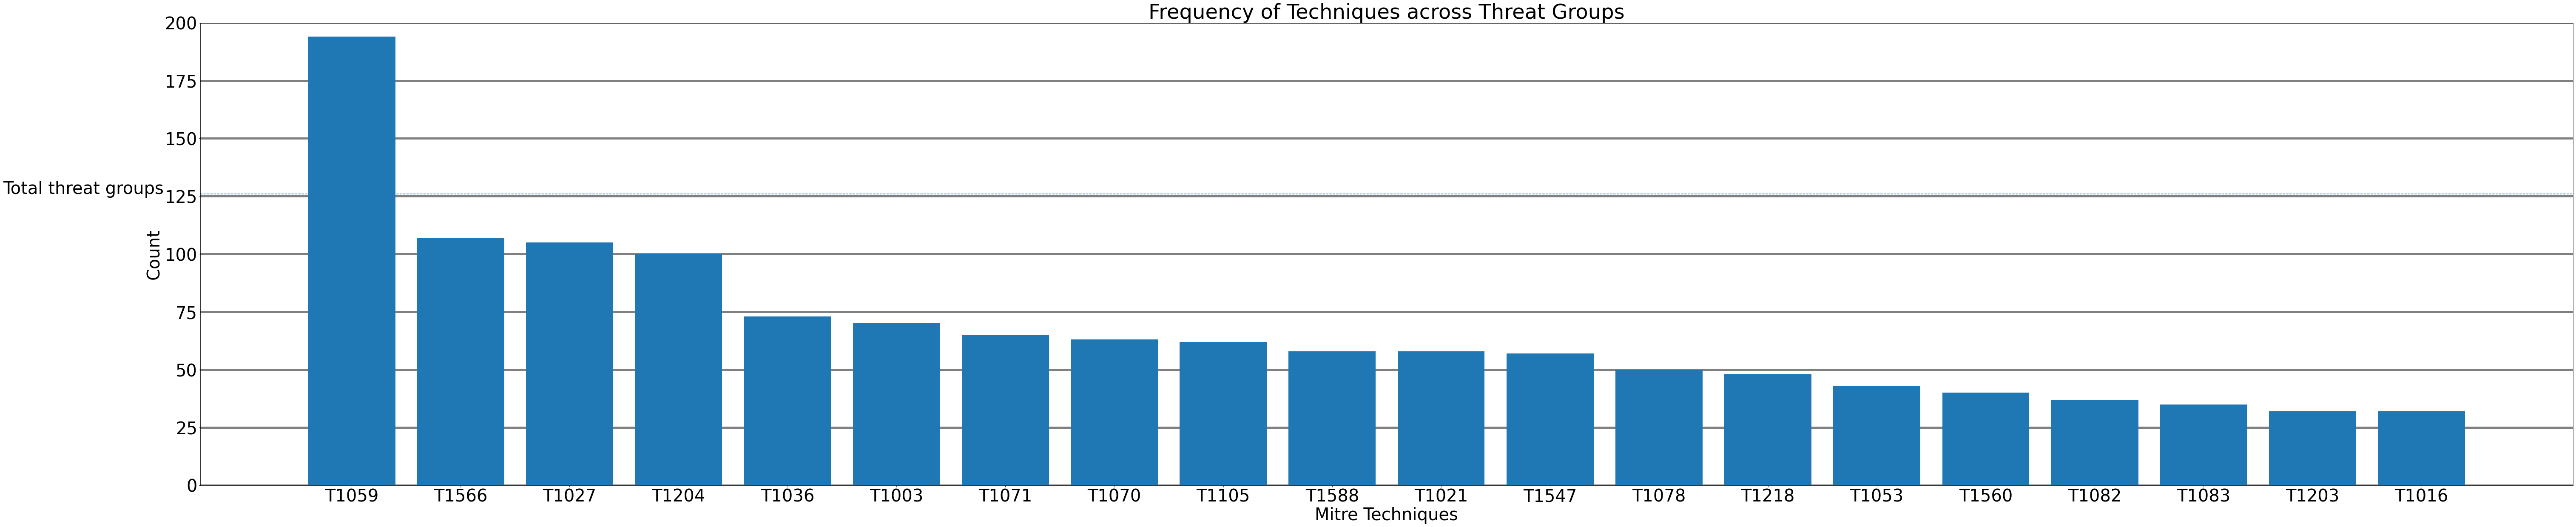

In [5]:
import matplotlib.pyplot as plt 

technique_count = {}
for row in df_group["techniques"].tolist():
    for dict in row:
        if dict["showSubtechniques"] == True and "score" not in dict:
            pass
        elif dict["showSubtechniques"] == True and "score" in dict:
            if dict["techniqueID"].split(".")[0] in technique_count:
                technique_count[dict["techniqueID"].split(".")[0]] += 1
            else:
                technique_count[dict["techniqueID"].split(".")[0]] = 1
        elif dict["showSubtechniques"] == False:
            if dict["techniqueID"] in technique_count:
                technique_count[dict["techniqueID"]] += 1
            else:
                technique_count[dict["techniqueID"]] = 1



with open("Mitre_results/technique_count.json", "w") as f:
    json.dump(technique_count, f)          

# visualise top 20    
plt.rcParams['figure.figsize'] = [100, 20]

x = sorted(technique_count, key=technique_count.get, reverse=True)[:20]
y = []
for i in x:
    y.append(technique_count[i])

plt.rcParams.update({'font.size': 40})
plt.ylim([0, 200])
plt.grid(axis="y", color="grey", linestyle='-', linewidth=5.0, zorder=2.5)
plt.axhline(126, ls="--")
plt.text(-3.2,126, "Total threat groups")
plt.xlabel("Mitre Techniques")
plt.ylabel("Count")
plt.title('Frequency of Techniques across Threat Groups')
plt.bar(x, y, alpha=1.0, zorder=2.6)  


The values presented could be considered misleading as we only have 126 groups in this data set so T1059 appearing ~190 times should not be possible.  
This is caused by the rounding up of the sub-techniques and counting each entry as a hit.  
Instead we need to calculate all hits for a technique (and its sub-techniques) as a single hit. 

We do this below.  


<BarContainer object of 20 artists>

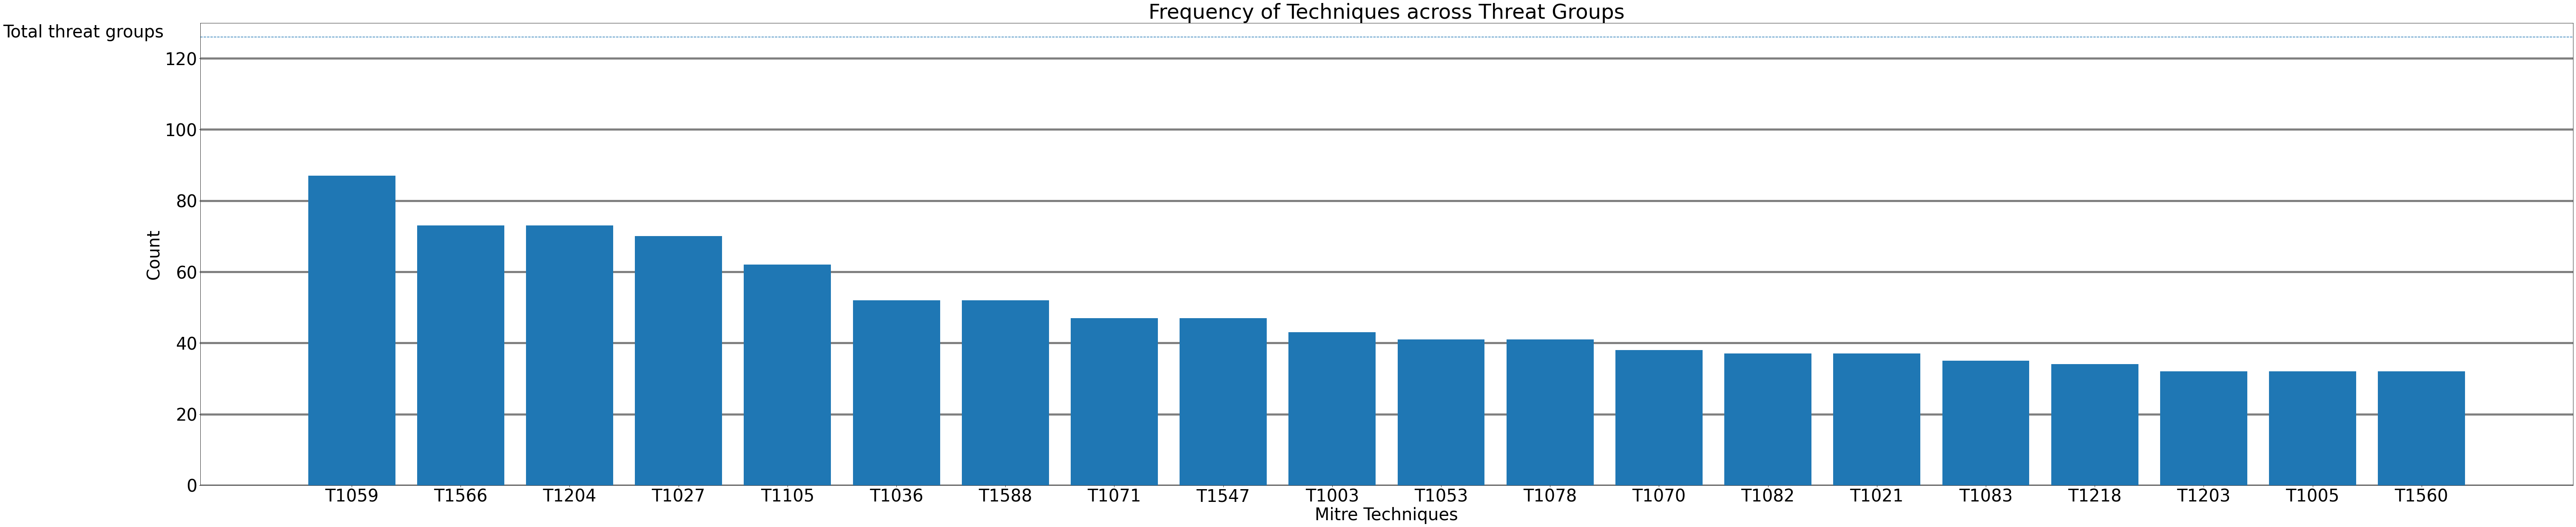

In [6]:
technique_count = {}

for row in df_group["techniques"].tolist():
    to_add = []
    for dict in row:
        if dict["showSubtechniques"] == True and "score" not in dict:
            pass
        elif dict["showSubtechniques"] == True and "score" in dict:
            to_add.append(dict["techniqueID"].split(".")[0])
        elif dict["showSubtechniques"] == False:
            to_add.append(dict["techniqueID"])
    to_add = list(dict.fromkeys(to_add))
    for m in to_add:
        if m not in technique_count:
            technique_count[m] = 1
        else:
            technique_count[m] += 1
            
with open("Mitre_results/technique_count.json", "w") as f:
    json.dump(technique_count, f)          

# visualise top 20    
plt.rcParams['figure.figsize'] = [100, 20]

x = sorted(technique_count, key=technique_count.get, reverse=True)[:20]
y = []
for i in x:
    y.append(technique_count[i])
    
plt.rcParams.update({'font.size': 40})
plt.ylim([0, 130])
plt.grid(axis="y", color="grey", linestyle='-', linewidth=5.0, zorder=2.5)
plt.axhline(126, ls="--")
plt.text(-3.2,126, "Total threat groups")
plt.xlabel("Mitre Techniques")
plt.ylabel("Count")
plt.title('Frequency of Techniques across Threat Groups')
plt.bar(x, y, alpha=1.0, zorder=2.6)  

## Technique Frequency inference

As we can see this data is far more intuitive.  
Below we will discuss about the top three techniques we see.

### T1059 (Command and Scripting Interpreter) 

T1059 appears in the TTPs of 69% of the given threat groups.  

The data demonstrates that the majority of threats actors will interact with a target systems via some form of CLI rather than GUI.
This is likely to take place after establishing Initial Access.  

This suggests that one of the most valuable ways to determine what has been done by a threat would be to enable full CLI logging.  
Simply relying on detecting and alerting for malicous usage of a CLI may leave you blind, given the vast amount of "legitimate" actions that could be taken and abused, as well as the vast ways to obfuscate CLI input.

### T1566 (Phishing)

T1566 appears in the TTPs of 58% of the given threat groups.  

It should come as no surprise to see Phishing high up on this list.  
In short, from a threat actors point of view, if it’s not broke why fix it.  

### T1204 (User Execution)

T1204 appears in the TTPs of 58% of the given threat groups. 

There has been a lot of coverage for 0-click infections, recently in the InfoSec community/news.  
Whilst this is clearly an issue, User Execution being so high up this ranking shows that getting an internal user to take some form of action is still often a requirement as part of threat actors TTPs.  

Typically when we think of Initial Access via clicking on phishing links or documents when it comes to User Execution.  
However, there are other aspects to this that should be considered such as maintaining persistence via macros in a already internal "trusted" document.  

<br>
<br>
<br>

## Sub-Technique Frequency

We now go on to analyse the data with each sub-technique as its own entity  


<BarContainer object of 20 artists>

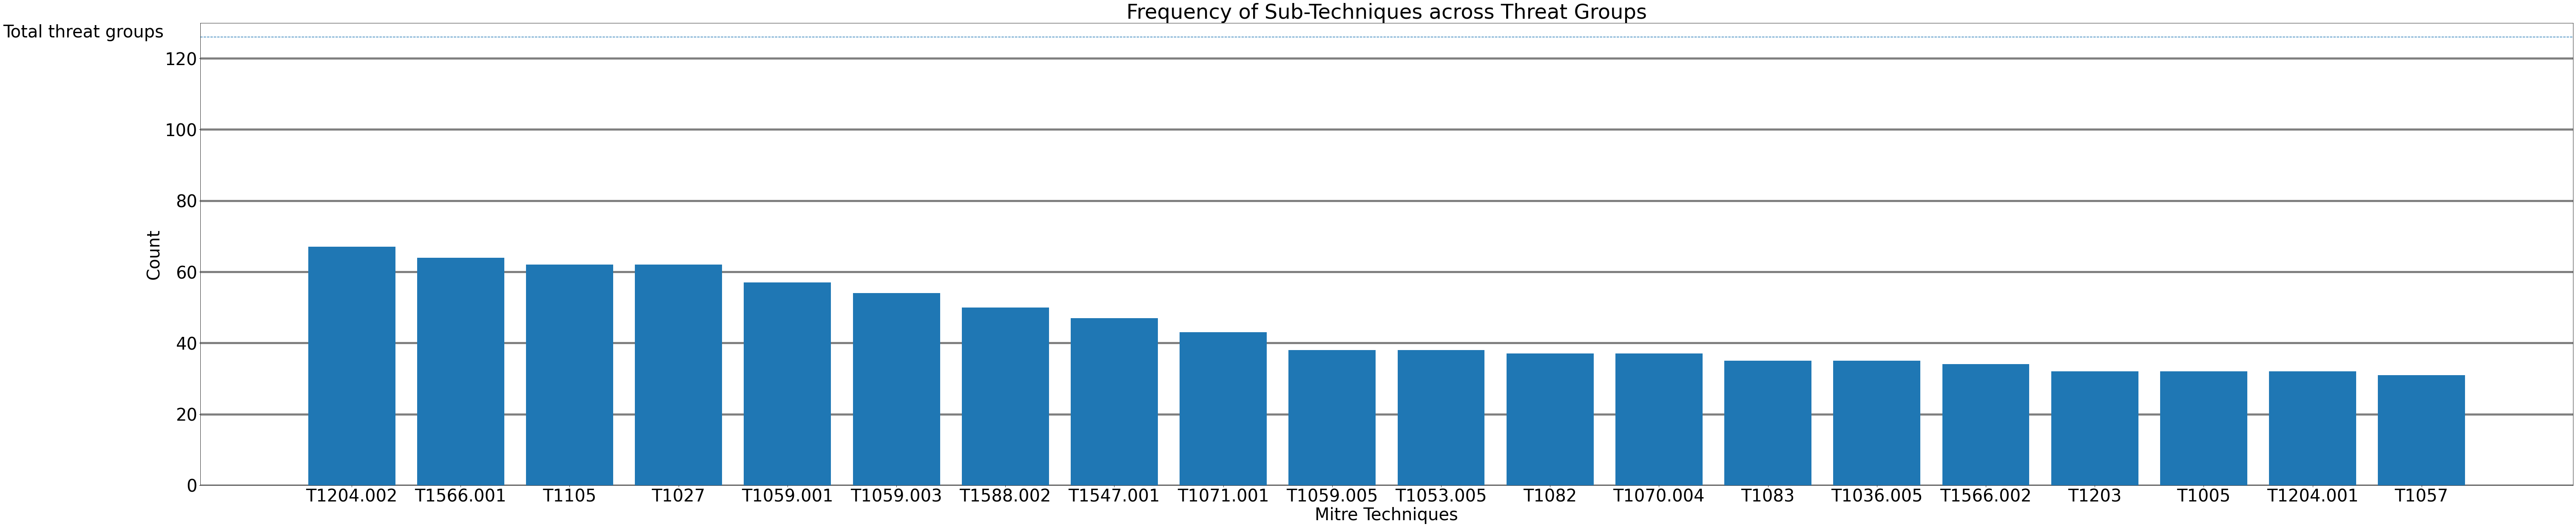

In [7]:
sub_technique_count = {}

for row in df_group["techniques"].tolist():
    for dict in row:
        if dict["showSubtechniques"] == True and "score" not in dict:
            pass
        elif dict["showSubtechniques"] == True and "score" in dict:
            if dict["techniqueID"] in sub_technique_count:
                sub_technique_count[dict["techniqueID"]] += 1
            else:
                sub_technique_count[dict["techniqueID"]] = 1
        elif dict["showSubtechniques"] == False:
            if dict["techniqueID"] in sub_technique_count:
                sub_technique_count[dict["techniqueID"]] += 1
            else:
                sub_technique_count[dict["techniqueID"]] = 1

with open("Mitre_results/sub_technique_count.json", "w") as f:
    json.dump(sub_technique_count, f)          

# visualise top 20    
x = sorted(sub_technique_count, key=sub_technique_count.get, reverse=True)[:20]
y = []
for i in x:
    y.append(sub_technique_count[i])


plt.rcParams.update({'font.size': 40})
plt.ylim([0, 130])
plt.grid(axis="y", color="grey", linestyle='-', linewidth=5.0, zorder=2.5)
plt.axhline(126, ls="--")
plt.text(-3.2,126, "Total threat groups")
plt.xlabel("Mitre Techniques")
plt.ylabel("Count")
plt.title('Frequency of Sub-Techniques across Threat Groups')
plt.bar(x, y, alpha=1.0, zorder=2.6)               


## Sub-Technique Frequency inference

Due to the breaking out of techniques into sub-techniques the percentages are on the most part going to seem less, and therefore those techniques without sub-techniques will be inflated relative to those that do not.  

### T1204.002 (User Execution: Malicous File)

T1204.002 appears in the TTPs of 53% of the given threat groups.  

When compared to the 14% for T1204.001 (User Execution: Malicous Link) and 1% for T1204.001 (User Execution: Malicous Image) it shows that malicous documents make up the majority of TTPs used by threat actors in order to utilise end users.  
This can likely be explained by having vastly more options available with regards to the type of documents, the ways to execute code from said documents and obfuscation of both, when compared to malicous links or images.  

This above point emphasising the focus on documents is further strengthened by T1566.001 (Phishing: Spear phishing Attachment) being almost twice as prevalent as T1566.002 (Phishing: Spear phishing Link).

### T1027 (Obfuscated Files or Information)

T1027 appears in the TTPs of 49% of the given threat groups.  

What is interesting about this is although there are 6 sub techniques for this technique it is still the high level technique that gets the most hits.  
With all sub-techniques combined making up 41% of the total hits for T1027.  

T1027.006 (HTML Smuggling) does not occur once in this data set, even though this technique has been discussed at length in the InfoSec community.  

The explanation for both the above could come down to the quality of reporting, or the more difficult to execute techniques are simply not necessary for Threat groups to adopt as currently more simple obfuscation, such as base64, allows them to achieve there goals.

### T1588.002 (Obtain Capabilities: Tool)

T1588.002 appears in the TTPs of 40% of the given threat groups.  
Almost the entirety of the hits under T1588 are T1588.002 (Obtain Capabilities: Tool), coming in at 86%.  

This highlights two things

That frequently tools are used from other resources rather than being internally developed.
Internal development is captured under T1587 which, including all sub-techniques only appears in 10% of the given threat groups.  

It also shows that the majority of tooling being used in this is not classed as malware by Mitre but are legitimate tools used for malicous purposes.  
Although this data does seem to hit a grey area when it comes to Penetration testing tools as shown by the following statement from Mitre.

"A tool can be used for malicious purposes by an adversary, but (unlike malware) were not intended to be used for those purposes (ex: PsExec). Tool acquisition can involve the procurement of commercial software licenses, including for red teaming tools such as Cobalt Strike."  
[link](https://attack.mitre.org/techniques/T1588/002/) 



### Note

Having an understanding of what percentage of a given high level technique is made up of which sub-techniques seems like a valuable piece of information for prioritising investigations and defences.  
This should be made a feature of the TTPredict program.  
<br>
<br> 


## Technique Co-Occurrence

Another interesting piece of data we can look to pull out is, given a certain technique, how likely are we to see another type of technique. 

We will start by getting a full list of all techniques, with and without sub-techniques.  
We then take this list and see how frequently we see the other techniques in conjunction with the original technique.  
Once we have our data we can visualise it.  
For this we will take the previously analysed top 20 and visualise the data using a heat map. 


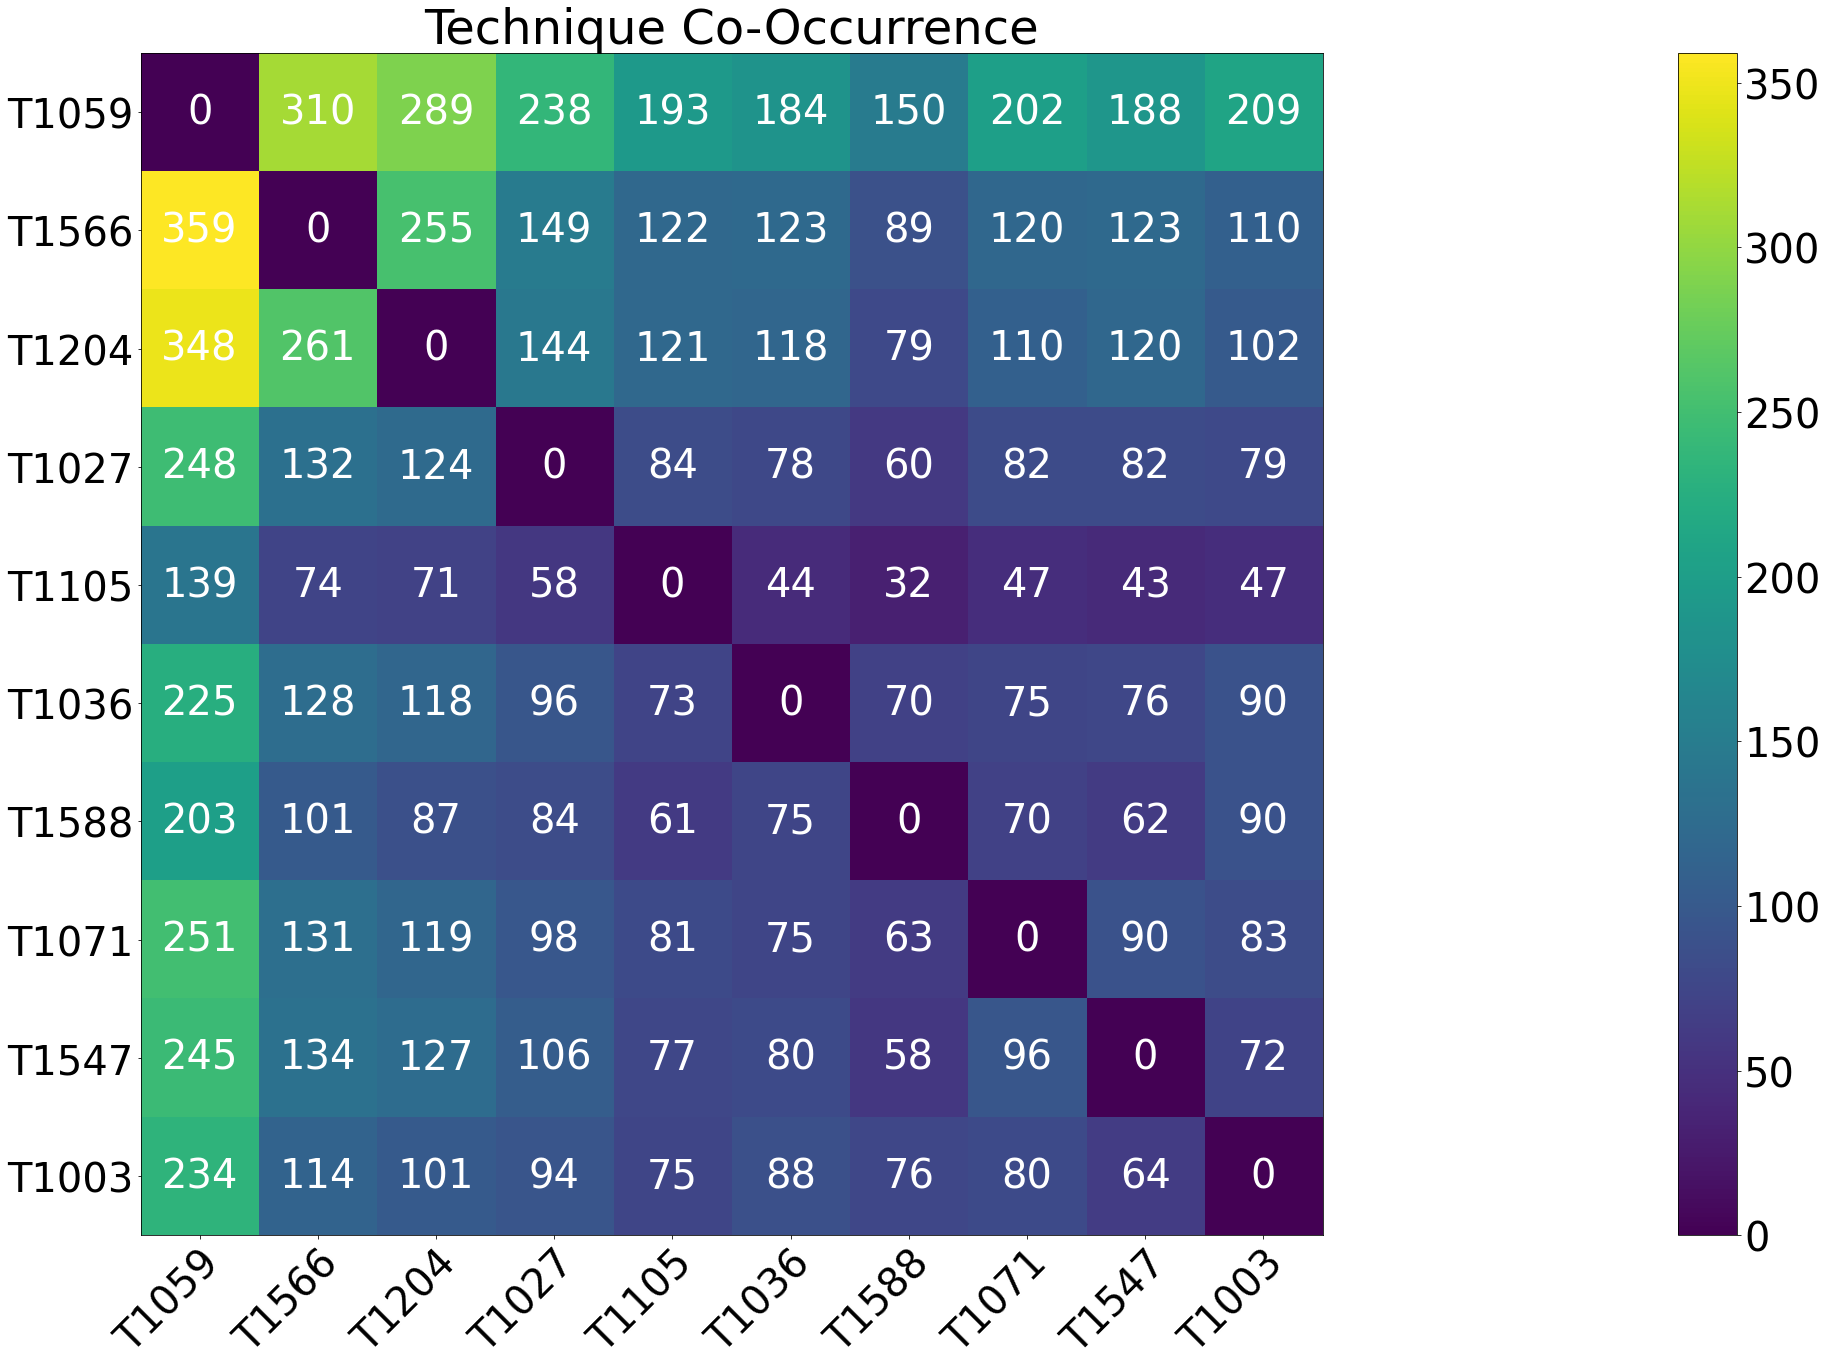

In [8]:
import numpy as np

with open("Mitre_data/MITRE_Techniques_edited.json", "r") as f:
    data = json.load(f)

all_tech = []
for i in data:
    for x in i["external_references"]:
        if x["source_name"] == "mitre-attack":
            if x["external_id"].split(".")[0] not in all_tech:
                all_tech.append(x["external_id"].split(".")[0]) 
    
all_tech_results = {}
for i in all_tech:
    all_tech_results[i] = {}
    for x in all_tech:
        all_tech_results[i][x] = 0

with open("Mitre_data/MITRE_Groups.json", "r") as f:
    data = json.load(f)
   
for i in all_tech:
    for x in data:
        for y in x["techniques"]:            
            if i in y["techniqueID"]:
                for z in x["techniques"]:
                    if i in z["techniqueID"]:
                        pass
                    else:
                        if "." not in z["techniqueID"] and z["showSubtechniques"] == False:
                            all_tech_results[i][z["techniqueID"]] += 1
                        elif "." in z["techniqueID"]:
                            all_tech_results[i][z["techniqueID"].split(".")[0]] += 1

with open("Mitre_results/technique_co_occurrence.json", "w") as f:
    json.dump(all_tech_results, f)
        
count = 10

with open("Mitre_results/technique_count.json", "r") as f:
    technique_count = json.load(f)         
x = sorted(technique_count, key=technique_count.get, reverse=True)[:count]
y = x

with open("Mitre_results/technique_co_occurrence.json", "r") as f:
    data = json.load(f)

array = []
for i in range (0 ,count):
    temp = []
    for r in range(0, count):
        temp.append(data[x[i]][y[r]])
    array.append(temp)

results = np.array(array)       

fig, ax = plt.subplots()
im = ax.imshow(results)
ax.set_xticks(np.arange(len(x)))
ax.set_yticks(np.arange(len(y)))
ax.set_xticklabels(x)
ax.set_yticklabels(y)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(y)):
    for j in range(len(x)):
        text = ax.text(j, i, results[i, j],
                       ha="center", va="center", color="w")

plt.colorbar(im)
ax.set_title("Technique Co-Occurrence")
fig.tight_layout()
plt.show()

This data does show what we would expect where the values of co-occurrence does trend with how often a given technique is seen in general.  
This is visualised by the trending down of values from the top left of the graph to the bottom right.  

However we have two issues here.  

The calculations are not commutative, this is due to the sub techniques being rolled up and appearing in different quantities depending on the technique you’re counting.  
For example T1059 has 8 sub-techniques, whereas T1566 only has 3 sub techniques so this could cause some skew of the data.
So we need to change how we calculate the occurrences of sub-techniques from rolling up individual sub-technique appearances to counting all appearances as one hit.  

There is also no real world representation of what the values mean, they only make sense in relation to each other.  
We can fix this by changing the value to a percentage of occurrences compared to the total number of appearances of one of the techniques.   


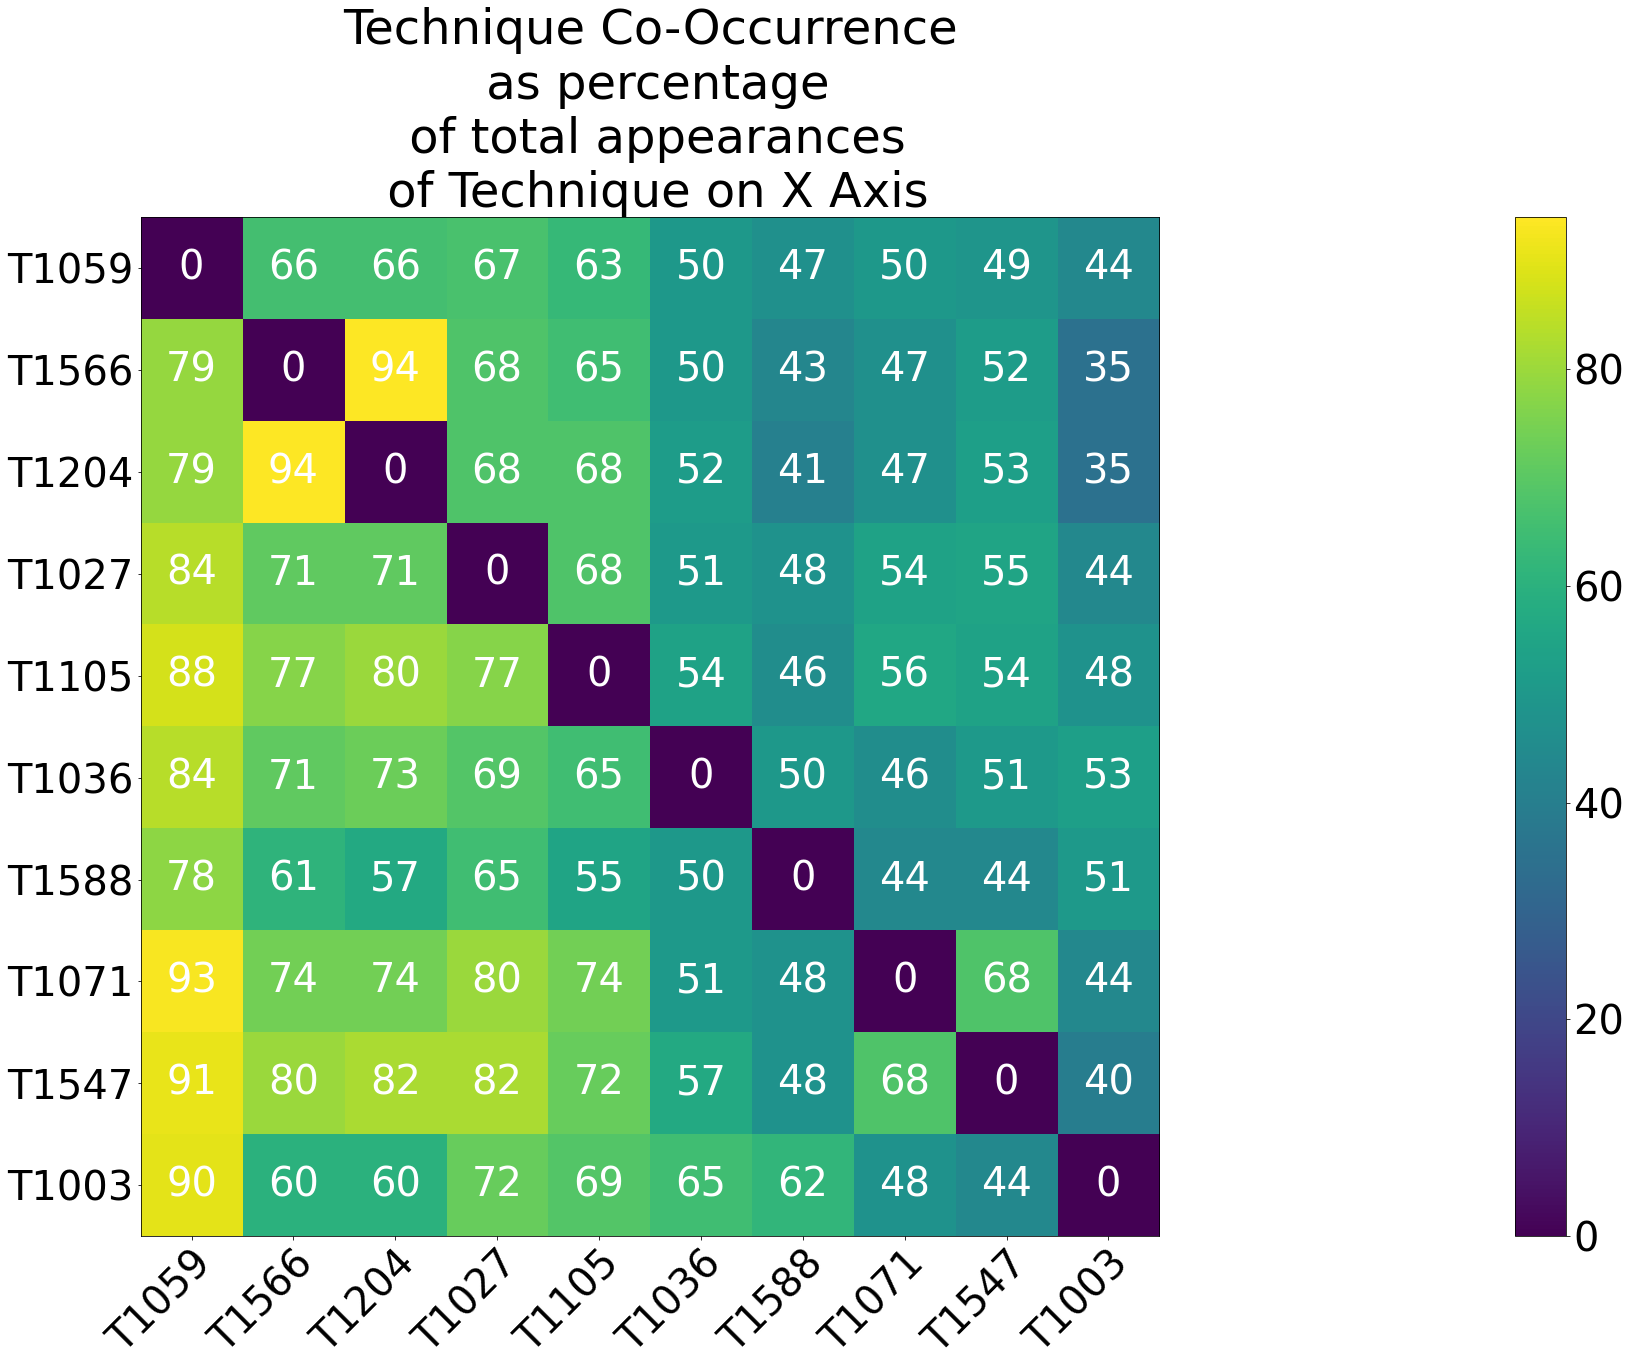

In [9]:
with open("Mitre_data/MITRE_Techniques_edited.json", "r") as f:
    data = json.load(f)

all_tech = []
for i in data:
    for x in i["external_references"]:
        if x["source_name"] == "mitre-attack":
            if x["external_id"].split(".")[0] not in all_tech:
                all_tech.append(x["external_id"].split(".")[0]) 
    
all_tech_results = {}
for i in all_tech:
    all_tech_results[i] = {}
    for x in all_tech:
        all_tech_results[i][x] = 0

with open("Mitre_data/MITRE_Groups.json", "r") as f:
    data = json.load(f)
   
for i in all_tech:
    for x in data:
        to_add = []
        for y in x["techniques"]:            
            if i in y["techniqueID"]:
                for z in x["techniques"]:
                    if i in z["techniqueID"]:
                        pass
                    elif "." not in z["techniqueID"] and z["showSubtechniques"] == False:
                        to_add.append(z["techniqueID"])
                    elif "." in z["techniqueID"]:
                        to_add.append(z["techniqueID"].split(".")[0])
        to_add = list(dict.fromkeys(to_add))
        for m in to_add:
            all_tech_results[i][m] += 1
            
                    
with open("Mitre_results/technique_co_occurrence.json", "w") as f:
    json.dump(all_tech_results, f)
        
count = 10

with open("Mitre_results/technique_count.json", "r") as f:
    technique_count = json.load(f)         
x = sorted(technique_count, key=technique_count.get, reverse=True)[:count]
y = x

with open("Mitre_results/technique_co_occurrence.json", "r") as f:
    data = json.load(f)

array = []
for i in range (0 ,count):
    temp = []
    hit = False
    for r in range(0, count):
        if data[x[i]][y[r]] == 0:
            temp.append(data[x[i]][y[r]])
        else:
            temp.append(int(((data[x[i]][y[r]])/technique_count[x[i]])*100))       
    array.append(temp)    

results = np.array(array)       

fig, ax = plt.subplots()
im = ax.imshow(results)
ax.set_xticks(np.arange(len(x)))
ax.set_yticks(np.arange(len(y)))
ax.set_xticklabels(x)
ax.set_yticklabels(y)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(y)):
    for j in range(len(x)):
        text = ax.text(j, i, results[i, j],
                       ha="center", va="center", color="w")

plt.colorbar(im)
ax.set_title("Technique Co-Occurrence\n as percentage\n of total appearances\n of Technique on X Axis")
fig.tight_layout()
plt.show()

Although useful what this heat map is predominantly showing us is that we are more likely to see high frequency Techniques having started with a different technique.  
What would be of more value would be to find the statistical anomalies in this data which should infer a stronger correlation between the two given techniques.   


In [10]:
with open("Mitre_data/MITRE_Techniques_edited.json", "r") as f:
    data = json.load(f)

all_tech = []
for i in data:
    for x in i["external_references"]:
        if x["source_name"] == "mitre-attack":
            if x["external_id"].split(".")[0] not in all_tech:
                all_tech.append(x["external_id"].split(".")[0]) 
    
all_tech_results = {}
for i in all_tech:
    all_tech_results[i] = {}
    for x in all_tech:
        all_tech_results[i][x] = 0

with open("Mitre_data/MITRE_Groups.json", "r") as f:
    data = json.load(f)
   
for i in all_tech:
    for x in data:
        to_add = []
        for y in x["techniques"]:            
            if i in y["techniqueID"]:
                for z in x["techniques"]:
                    if i in z["techniqueID"]:
                        pass
                    elif "." not in z["techniqueID"] and z["showSubtechniques"] == False:
                        to_add.append(z["techniqueID"])
                    elif "." in z["techniqueID"]:
                        to_add.append(z["techniqueID"].split(".")[0])
        to_add = list(dict.fromkeys(to_add))
        for m in to_add:
            all_tech_results[i][m] += 1
            
                    
with open("Mitre_results/technique_co_occurrence.json", "w") as f:
    json.dump(all_tech_results, f)
        
count = 144

with open("Mitre_results/technique_count.json", "r") as f:
    technique_count = json.load(f)         
x = sorted(technique_count, key=technique_count.get, reverse=True)[:count]
y = x

with open("Mitre_results/technique_co_occurrence.json", "r") as f:
    data = json.load(f)


def find_anomalies(data):
    # define a list to accumulate anomalies
    anomalies = []
    # Set upper limit to 2.5 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 3.5 #3.85

    upper_limit = data_mean + anomaly_cut_off
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit:
            anomalies.append(outlier)
    return anomalies    
   
array = []
for i in range (0 ,count):
    temp = []
    for r in range(0, count):
        if data[x[i]][y[r]] == 0:
            temp.append(data[x[i]][y[r]])
        else:
            temp.append(int(((data[x[i]][y[r]])/technique_count[x[i]])*100))       
    array.append(temp)   

results = np.array(array)  

count = 0
data = []
for d in results:
    anom = find_anomalies(d)
    if anom:
        for p in anom:
            temp = [x[count],technique_count[x[count]], x[np.where(d == p)[0][0]], p]
            data.append(temp)
    count += 1

df = pd.DataFrame(data, columns=["Original Technique", "Original Technique Count", "Secondary Technique", "Co-Occurrence Percentage"])
    
df.head(20)
 


,Original Technique,Original Technique Count,Secondary Technique,Co-Occurrence Percentage
0,T1566,73,T1059,79
1,T1566,73,T1204,94
2,T1204,73,T1059,79
3,T1204,73,T1566,94
4,T1027,70,T1059,84
5,T1105,62,T1059,88
6,T1105,62,T1204,80
7,T1036,52,T1059,84
8,T1588,52,T1059,78
9,T1071,47,T1059,93


## Technique Co-Occurrence inference

### T1059 (Command and Scripting Interpreter)

It should be unsurprising to see that T1059 (Command and Scripting Interpreter) is seen with a high level of co-occurrence across a number techniques.  
This will be due to being the highest frequency technique as well as being used as the initial starting point for other techniques (rather than a true dependency) the due to the preference of CLI from threat actors.  

### Top Four Rows

If we group the top 4 rows together it paints the picture of a standard phishing attack in order to trick the user into executing something to provide CLI access to a threat actor.  
<br>
<br> 


Given the prevalence of T1059 as a secondary technique in the dataframe it may be worth looking at all entries where this is not the case.

In [11]:
df[~df["Secondary Technique"].str.contains("T1059")].head(20)

,Original Technique,Original Technique Count,Secondary Technique,Co-Occurrence Percentage
1,T1566,73,T1204,94
3,T1204,73,T1566,94
6,T1105,62,T1204,80
19,T1203,32,T1566,93
20,T1203,32,T1204,90
25,T1189,24,T1566,83
26,T1189,24,T1566,83
41,T1568,7,T1566,100
42,T1195,6,T1566,100


### T1203 (Exploitation for Client Execution) and T1566 (Phishing) / T1204 (User Execution)

These three techniques being used together could demonstrate that threat actors using vulnerabilities as part of their phishing payloads.  

### T1189 (Drive-by Compromise) and T1566 (Phishing)

T1566 (Drive-by Compromise) being seen with T1566 (Phishing) could indicate that certain threat actors are luring targets to pre-compromised websites in order to compromise there systems further.  
This for example could be for credential harvesting, serve malicous ads or to execute malicous Java script.  
The reasoning behind this being a lower total count than say the document based phishing could in part be due to the increased security of browsers due to techniques such as sandboxing.  

There is also the possibility that these two techniques, although both used by multiple threat actors, are not related but are actually substitutes.  
For example a threat actor may attempt to phish a target but not have any positive results, they then may move on to a waterhole attack (Drive-by Compromise) due to the previous failed attempt.

### T1568 (Dynamic Resolution) / T1195 (Supply Chain Compromise) and T1566 (Phishing)

If the first thing you see is the 100% co-occurrence percentage you may be inclined to assume that we would only see T1568 (Dynamic Resolution) and T1195 (Supply Chain Compromise ) when we see T1566 (Phishing).  
However the fact that T1568 and T1195 are only in the TTPs of 6% and 5% of threat actors respectively, reducing the confidence in this inference.  



<br>
<br>
Although this analysis has thrown up some interesting points potentially the Sub-Technique Co-Occurrence may provide more.


## Sub-Technique Co-Occurrence


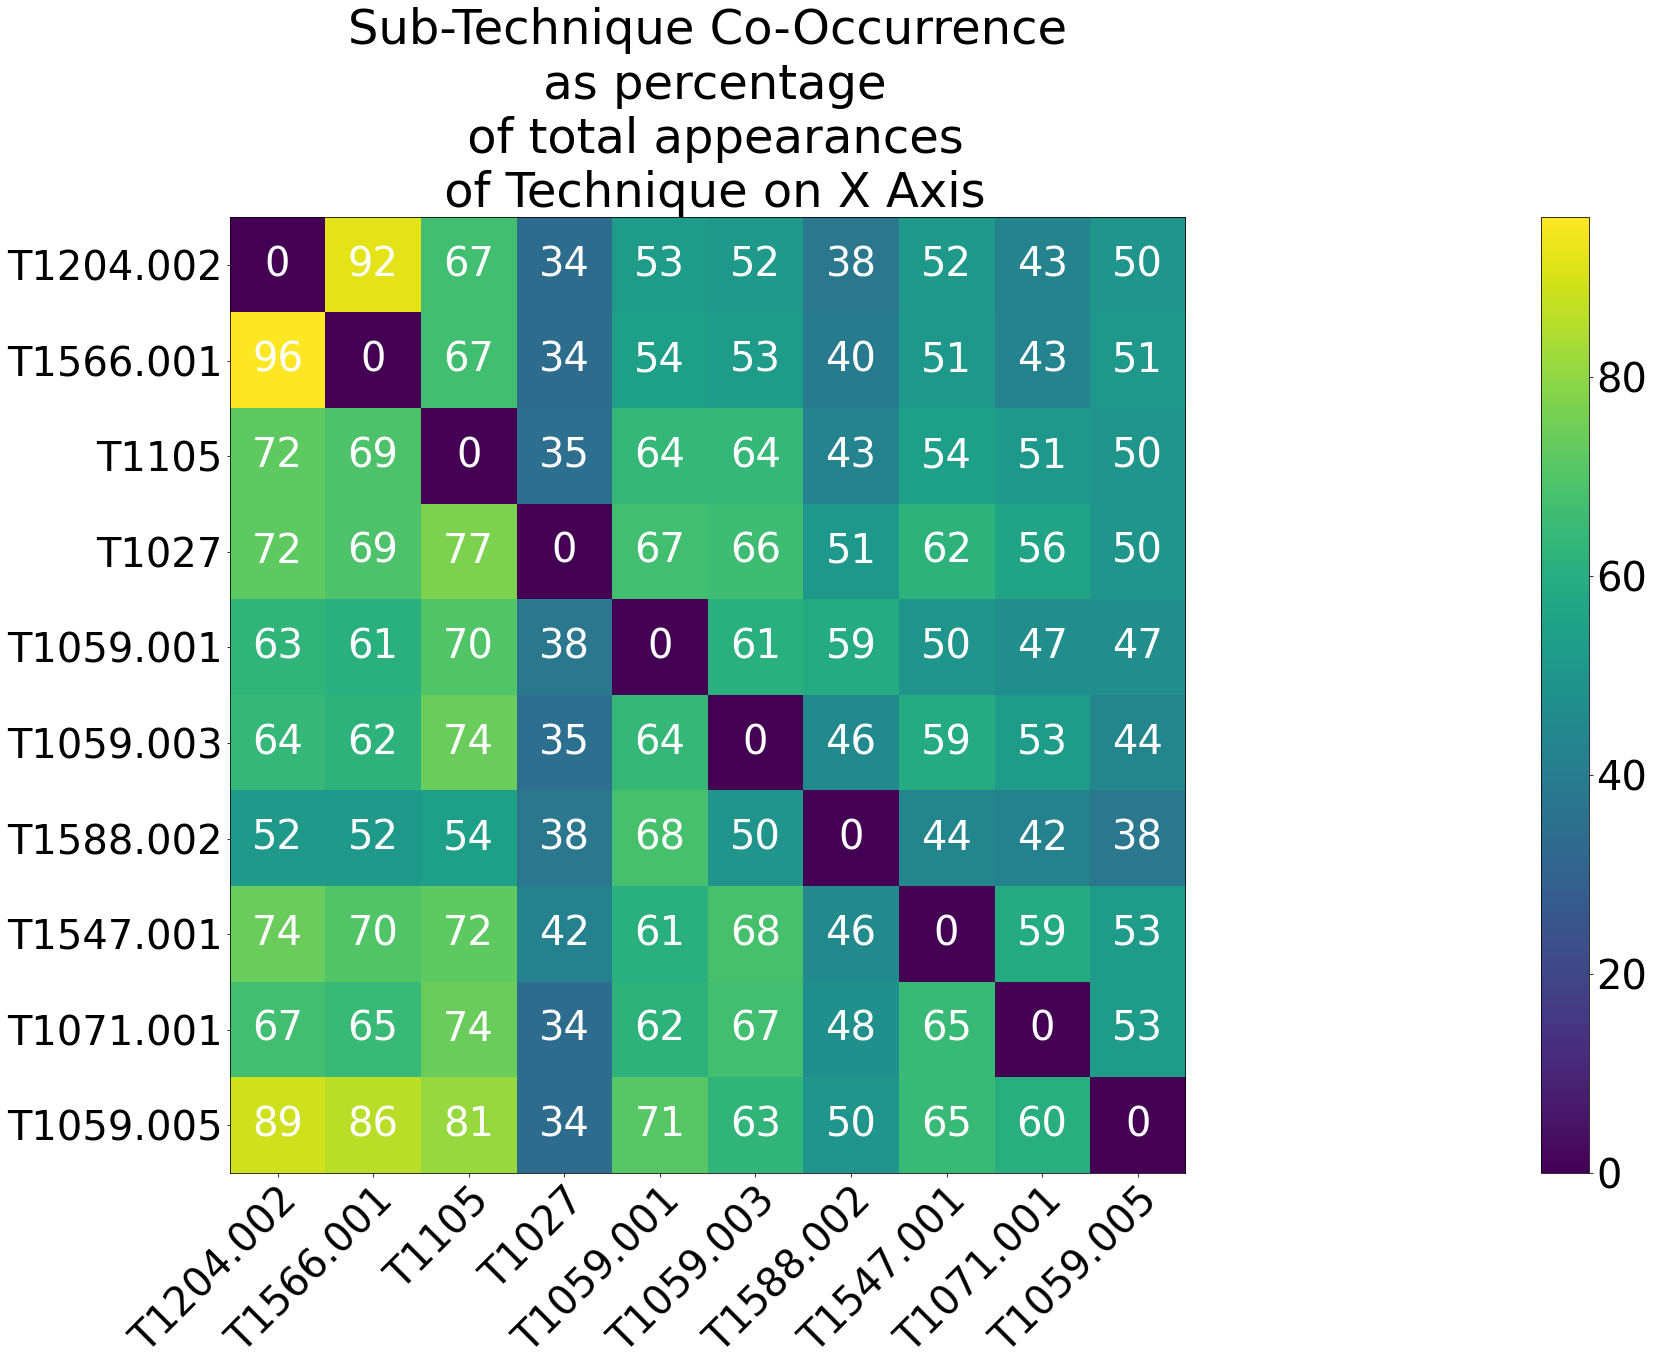

In [12]:
with open("Mitre_data/MITRE_Techniques_edited.json", "r") as f:
    data = json.load(f)

all_tech = []
for i in data:
    for x in i["external_references"]:
        if x["source_name"] == "mitre-attack":
            if x["external_id"] not in all_tech:
                all_tech.append(x["external_id"]) 
    
all_tech_results = {}
for i in all_tech:
    all_tech_results[i] = {}
    for x in all_tech:
        all_tech_results[i][x] = 0

with open("Mitre_data/MITRE_Groups.json", "r") as f:
    data = json.load(f)
   
for i in all_tech:
    for x in data:
        to_add = []
        for y in x["techniques"]:            
            if i in y["techniqueID"]:
                for z in x["techniques"]:
                    if i in z["techniqueID"]:
                        pass
                    elif "." not in z["techniqueID"] and z["showSubtechniques"] == False:
                        to_add.append(z["techniqueID"])
                    elif "." in z["techniqueID"]:
                        to_add.append(z["techniqueID"])
        to_add = list(dict.fromkeys(to_add))
        for m in to_add:
            all_tech_results[i][m] += 1
            
                    
with open("Mitre_results/sub_technique_co_occurrence.json", "w") as f:
    json.dump(all_tech_results, f)
        
count = 10

with open("Mitre_results/sub_technique_count.json", "r") as f:
    technique_count = json.load(f)         
x = sorted(technique_count, key=technique_count.get, reverse=True)[:count]
y = x

with open("Mitre_results/sub_technique_co_occurrence.json", "r") as f:
    data = json.load(f)

array = []
for i in range (0 ,count):
    temp = []
    hit = False
    for r in range(0, count):
        if data[x[i]][y[r]] == 0:
            temp.append(data[x[i]][y[r]])
        else:
            temp.append(int(((data[x[i]][y[r]])/technique_count[x[i]])*100))       
    array.append(temp)    

results = np.array(array)       

fig, ax = plt.subplots()
im = ax.imshow(results)
ax.set_xticks(np.arange(len(x)))
ax.set_yticks(np.arange(len(y)))
ax.set_xticklabels(x)
ax.set_yticklabels(y)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(y)):
    for j in range(len(x)):
        text = ax.text(j, i, results[i, j],
                       ha="center", va="center", color="w")

plt.colorbar(im)
ax.set_title("Sub-Technique Co-Occurrence\n as percentage\n of total appearances\n of Technique on X Axis")
fig.tight_layout()
plt.show()

As before we will likely get more value by finding the statistical anomalies in this data which should infer a stronger correlation between the two given techniques.   

In [13]:
with open("Mitre_data/MITRE_Techniques_edited.json", "r") as f:
    data = json.load(f)

all_tech = []
for i in data:
    for x in i["external_references"]:
        if x["source_name"] == "mitre-attack":
            if x["external_id"] not in all_tech:
                all_tech.append(x["external_id"]) 
    
all_tech_results = {}
for i in all_tech:
    all_tech_results[i] = {}
    for x in all_tech:
        all_tech_results[i][x] = 0

with open("Mitre_data/MITRE_Groups.json", "r") as f:
    data = json.load(f)
   
for i in all_tech:
    for x in data:
        to_add = []
        for y in x["techniques"]:            
            if i in y["techniqueID"]:
                for z in x["techniques"]:
                    if i in z["techniqueID"]:
                        pass
                    elif "." not in z["techniqueID"] and z["showSubtechniques"] == False:
                        to_add.append(z["techniqueID"])
                    elif "." in z["techniqueID"]:
                        to_add.append(z["techniqueID"])
        to_add = list(dict.fromkeys(to_add))
        for m in to_add:
            all_tech_results[i][m] += 1
            
                    
with open("Mitre_results/sub_technique_co_occurrence.json", "w") as f:
    json.dump(all_tech_results, f)


count = 281

with open("Mitre_results/sub_technique_count.json", "r") as f:
    technique_count = json.load(f) 

x = sorted(technique_count, key=technique_count.get, reverse=True)[:count]
y = x

with open("Mitre_results/sub_technique_co_occurrence.json", "r") as f:
    data = json.load(f)


def find_anomalies(data):
    anomalies = []
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 3.5 #3.5
    upper_limit = data_mean + anomaly_cut_off
    for outlier in data:
        if outlier > upper_limit:
            anomalies.append(outlier)
    return anomalies    
   
array = []
for i in range (0 ,count):
    temp = []
    for r in range(0, count):
        if data[x[i]][y[r]] == 0:
            temp.append(data[x[i]][y[r]])
        else:
            temp.append(int(((data[x[i]][y[r]])/technique_count[x[i]])*100))       
    array.append(temp)   

results = np.array(array)  

count = 0
data = []
for d in results:
    anom = find_anomalies(d)
    if anom:
        for p in anom:
            temp = [x[count],technique_count[x[count]], x[np.where(d == p)[0][0]], p]
            data.append(temp)
    count += 1

df = pd.DataFrame(data, columns=["Original Sub-Technique", "Original Sub-Technique Count", "Secondary Technique", "Co-Occurrence Percentage"])
    
df.head(20)
 


,Original Sub-Technique,Original Sub-Technique Count,Secondary Technique,Co-Occurrence Percentage
0,T1204.002,67,T1566.001,92
1,T1204.002,67,T1105,67
2,T1204.002,67,T1059.001,53
3,T1204.002,67,T1059.003,52
4,T1204.002,67,T1059.003,52
5,T1204.002,67,T1059.005,50
6,T1566.001,64,T1204.002,96
7,T1566.001,64,T1105,67
8,T1566.001,64,T1059.001,54
9,T1566.001,64,T1059.003,53


## Sub-Technique Co-Occurrence inference

Due to the breakdown of sub-techniques certain high level technique will be relatively inflated if they do not have sub-techniques such as T1105.  

## T1204.002 (User Execution: Malicious File) and T1566.001 (Phishing: Spear phishing Attachment)

Earlier in our analysis we made the assumption, based on two high data points, that T1204.002 (User Execution: Malicious File) and T1566.001 (Phishing: Spear phishing Attachment) were linked.  
From this analysis we seem to have confirmed that.  

## T1059.X

The same three sub-techniques routinely appear more often than others, those being  T1059.001 (PowerShell)  T1059.003 (Windows Command Shell) T1059.005 (Visual Basic).  
The reasoning for this is likely that this data set seems to be skewed towards initial access, rather than post exploitation.  
This is understandable given the following points,  

1. Businesses are more likely to share their findings if they have detected a threat actor post initial access but before they achieve there goals.
2. By numbers there will be a larger ratio of initial access attempts compared to post exploitation, due to failed attempts.  

